### Librerías necesarias

In [1]:
import pydeck as pdk
import pandas as pd
import numpy as np
import ipywidgets
import json
import psycopg2
import random
import time
import csv
import os
import matplotlib.pyplot as plt
import plotly.express as px
from prophet import Prophet

### Carga de datos

In [2]:
# Ruta de la carpeta que contiene los archivos CSV que queremos leer
carpeta_csv = 'Datos'

# Obtenemos la lista de archivos CSV en la carpeta
archivos_csv = [archivo_csv for archivo_csv in os.listdir(carpeta_csv) if archivo_csv.endswith('.csv')]

# Inicializamos un DataFrame vacío en el que vamos a almacenar todo el conjunto de los datos 
df = pd.DataFrame()

# Iteramos sobre los archivos CSV y cargaos los datos en el DataFrame previamente creado
for csv_file_path in archivos_csv:
    #Creamos un DataFrame temporal a partir del CSV
    temp_df = pd.read_csv(os.path.join(carpeta_csv, csv_file_path), sep=';', encoding='ISO-8859-1')
    
    # Se eliminan las filas que contienen solo valores nulos o vacíos ya que los archivos CSV van separados por una fila en blanco
    temp_df.dropna(how='all', inplace=True)
    
    # Se concatena el DataFrame temporal con el DataFrame principal
    df = pd.concat([df, temp_df], ignore_index=True)

C:\Users\celiu\AppData\Local\Temp\ipykernel_13616\1594789995.py:13: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(os.path.join(carpeta_csv, csv_file_path), sep=';', encoding='ISO-8859-1')
C:\Users\celiu\AppData\Local\Temp\ipykernel_13616\1594789995.py:13: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(os.path.join(carpeta_csv, csv_file_path), sep=';', encoding='ISO-8859-1')
C:\Users\celiu\AppData\Local\Temp\ipykernel_13616\1594789995.py:13: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(os.path.join(carpeta_csv, csv_file_path), sep=';', encoding='ISO-8859-1')
C:\Users\celiu\AppData\Local\Temp\ipykernel_13616\1594789995.py:13: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(os.pat

In [3]:
#Visualizamos el DataFrame cargado
df.head(5)

fecha                              idTrip  idBike  fleet  \
0  2022-01-01  489978239_1718_2022-01-01T00:18:37  1718.0    1.0   
1  2022-01-01  06023769T_7340_2022-01-01T00:14:59  7340.0    1.0   
2  2022-01-01  50856526F_3861_2022-01-01T00:09:50  3861.0    1.0   
3  2022-01-01  79006741Q_7657_2022-01-01T00:16:29  7657.0    1.0   
4  2022-01-01  76959007H_6653_2022-01-01T00:18:01  6653.0    1.0   

   trip_minutes                                 geolocation_unlock  \
0         16.28  {'type': 'Point', 'coordinates': [-3.6714166, ...   
1          7.10  {'type': 'Point', 'coordinates': [-3.6894193, ...   
2          0.48  {'type': 'Point', 'coordinates': [-3.688822, 4...   
3          6.62  {'type': 'Point', 'coordinates': [-3.6653055, ...   
4          8.07  {'type': 'Point', 'coordinates': [-3.6983055, ...   

  address_unlock          unlock_date locktype unlocktype  \
0            NaN  2022-01-01T00:02:20  STATION    STATION   
1            NaN  2022-01-01T00:07:53  STATION    STATION   
2            NaN  2022-01-01T00:09:21  STATION    STATION   
3            NaN  2022-01-01T00:09:52  STATION    STATION   
4            NaN  2022-01-01T00:09:57  STATION    STATION   

                                    geolocation_lock address_lock  \
0  {'type': 'Point', 'coordinates': [-3.688398, 4...          NaN   
1  {'type': 'Point', 'coordinates': [-3.6993465, ...          NaN   
2  {'type': 'Point', 'coordinates': [-3.688822, 4...          NaN   
3  {'type': 'Point', 'coordinates': [-3.6657777, ...          NaN   
4  {'type': 'Point', 'coordinates': [-3.7025024, ...          NaN   

             lock_date station_unlock  dock_unlock       unlock_station_name  \
0  2022-01-01T00:18:37          200.0          3.0    Avenida de los Toreros   
1  2022-01-01T00:14:59           69.0          5.0             Antonio Maura   
2  2022-01-01T00:09:50           73.0         21.0  Puerta del Ãngel CaÃ­do   
3  2022-01-01T00:16:29          192.0         22.0         MarquÃ©s de Zafra   
4  2022-01-01T00:18:01          183.0          3.0     Jaime el Conquistador   

   station_lock  dock_lock          lock_station_name  
0          64.0        4.0  Plaza de la Independencia  
1         169.0       17.0             Manuel Silvela  
2          73.0       21.0   Puerta del Ãngel CaÃ­do  
3         190.0       17.0                Parque Roma  
4          47.0       24.0            JesÃºs y MarÃ­a

### Guardamos el DataFrame en un archivo CSV

In [4]:
#Guardamos el DataFrame en un CSV para tener todos los resultados juntos
df.to_csv('resultados_combinados.csv',sep=';')

### Análisis de los datos

In [5]:
# Extraemos la información básica del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4440057 entries, 0 to 4440056
Data columns (total 19 columns):
 #   Column               Dtype  
---  ------               -----  
 0   fecha                object 
 1   idTrip               object 
 2   idBike               float64
 3   fleet                float64
 4   trip_minutes         float64
 5   geolocation_unlock   object 
 6   address_unlock       object 
 7   unlock_date          object 
 8   locktype             object 
 9   unlocktype           object 
 10  geolocation_lock     object 
 11  address_lock         object 
 12  lock_date            object 
 13  station_unlock       object 
 14  dock_unlock          float64
 15  unlock_station_name  object 
 16  station_lock         float64
 17  dock_lock            float64
 18  lock_station_name    object 
dtypes: float64(6), object(13)
memory usage: 643.6+ MB


In [6]:
#Se analiza descriptivamente aquellas columnas numéricas del DataFrame.
df.describe()

idBike         fleet  trip_minutes   dock_unlock  station_lock  \
count  4.440057e+06  4.440057e+06  4.440057e+06  4.422474e+06  4.419186e+06   
mean   5.674513e+03  1.007832e+00  2.263083e+01  1.237403e+01  1.273205e+02   
std    2.100869e+03  8.815321e-02  2.823059e+02  7.560388e+00  7.533595e+01   
min    0.000000e+00  1.000000e+00 -8.677330e+03  1.000000e+00  1.000000e+00   
25%    4.567000e+03  1.000000e+00  5.730000e+00  5.000000e+00  5.800000e+01   
50%    6.282000e+03  1.000000e+00  1.062000e+01  1.200000e+01  1.280000e+02   
75%    7.368000e+03  1.000000e+00  1.643000e+01  1.900000e+01  1.900000e+02   
max    8.090000e+03  2.000000e+00  4.179560e+04  3.000000e+01  8.890000e+02   

          dock_lock  
count  4.419186e+06  
mean   1.239518e+01  
std    7.582816e+00  
min    1.000000e+00  
25%    5.000000e+00  
50%    1.200000e+01  
75%    1.900000e+01  
max    3.000000e+01

In [7]:
#Mostramos la cantidad de valores nulos que hay en cada columna
df.isnull().sum()

fecha                        0
idTrip                 2337068
idBike                       0
fleet                        0
trip_minutes                 0
geolocation_unlock           0
address_unlock          548477
unlock_date                  0
locktype                     0
unlocktype                   0
geolocation_lock             0
address_lock            547606
lock_date                    0
station_unlock           17583
dock_unlock              17583
unlock_station_name      17583
station_lock             20871
dock_lock                20871
lock_station_name        20871
dtype: int64

In [8]:
#Estudiamos la columna idTrip.
print (f"{df[df['idTrip'].isnull()]}")

#Nos damos cuenta de que los datos a partir del 1 de febrero no tienen idTrip por lo cual podríamos eliminar esa columna.

              fecha idTrip  idBike  fleet  trip_minutes  \
244760   2022-02-01    NaN  5687.0    1.0          5.03   
244761   2022-02-01    NaN  4773.0    1.0         11.18   
244762   2022-02-01    NaN   659.0    1.0          7.18   
244763   2022-02-01    NaN  7249.0    1.0         22.03   
244764   2022-02-01    NaN  4353.0    1.0         10.25   
...             ...    ...     ...    ...           ...   
4440052  2023-01-31    NaN  7277.0    1.0          9.35   
4440053  2023-01-31    NaN  7520.0    1.0          5.05   
4440054  2023-01-31    NaN  6812.0    1.0          9.68   
4440055  2023-01-31    NaN   394.0    1.0          5.88   
4440056  2023-01-31    NaN  1804.0    1.0         20.98   

                                        geolocation_unlock  \
244760   {'type': 'Point', 'coordinates': [-3.7007111, ...   
244761   {'type': 'Point', 'coordinates': [-3.6787441, ...   
244762   {'type': 'Point', 'coordinates': [-3.6933498, ...   
244763   {'type': 'Point', 'coordinates': [

In [9]:
#Estudiamos las otras dos columnas que más valores nulos tenemos
# Columna que voy a verificar
columna_a_verificar = 'address_unlock'

# Compruebo la columna que tiene valores nulos
columna_tiene_nulos = df[columna_a_verificar].isnull().any()

if columna_tiene_nulos:
    print(f"La columna '{columna_a_verificar}' tiene al menos un valor nulo.")
else:
    print(f"La columna '{columna_a_verificar}' no tiene valores nulos.")
    
# Contamos los valores nulos en la columna
cantidad_nulos = df[columna_a_verificar].isnull().sum()

print(f"La columna '{columna_a_verificar}' tiene {cantidad_nulos} valores nulos.")
print(f"Valores en el dataframe: {len(df)}")

#Nos damos cuenta de que el 12.35% de los datos tienen los valores de la columna address_unlock nulos.
#No le vamos a dar importancia dado que para pintar los puntos en el mapa utilizaremos siempre las coordenadas.

La columna 'address_unlock' tiene al menos un valor nulo.
La columna 'address_unlock' tiene 548477 valores nulos.
Valores en el dataframe: 4440057


In [10]:
# Columna que voy a verificar
columna_a_verificar = 'address_lock'

# Compruebo la columna tiene valores nulos
columna_tiene_nulos = df[columna_a_verificar].isnull().any()

if columna_tiene_nulos:
    print(f"La columna '{columna_a_verificar}' tiene al menos un valor nulo.")
else:
    print(f"La columna '{columna_a_verificar}' no tiene valores nulos.")
    
# Contamos los valores nulos en la columna
cantidad_nulos = df[columna_a_verificar].isnull().sum()

print(f"La columna '{columna_a_verificar}' tiene {cantidad_nulos} valores nulos.")
print(f"Valores en el dataframe: {len(df)}")

#Nos damos cuenta de que el 12.33% de los datos tienen los valores de la columna address_lock nulos.
#No le vamos a dar importancia dado que para pintar los puntos en el mapa utilizaremos siempre las coordenadas.

La columna 'address_lock' tiene al menos un valor nulo.
La columna 'address_lock' tiene 547606 valores nulos.
Valores en el dataframe: 4440057


### Procesamiento de los datos

In [11]:
columnas_a_procesar = ['geolocation_unlock', 'geolocation_lock']

# Iteramos sobre las columnas a procesar y aplicar la lógica
for columna in columnas_a_procesar:
    # Convertimos las coordenadas de geolocalización a columnas separadas de latitud y longitud
    df[[f'{columna}_longitud', f'{columna}_latitud']] = pd.DataFrame(df[columna].apply(eval).apply(lambda x: x['coordinates']).tolist(), index=df.index)

df.head(5)

fecha                              idTrip  idBike  fleet  \
0  2022-01-01  489978239_1718_2022-01-01T00:18:37  1718.0    1.0   
1  2022-01-01  06023769T_7340_2022-01-01T00:14:59  7340.0    1.0   
2  2022-01-01  50856526F_3861_2022-01-01T00:09:50  3861.0    1.0   
3  2022-01-01  79006741Q_7657_2022-01-01T00:16:29  7657.0    1.0   
4  2022-01-01  76959007H_6653_2022-01-01T00:18:01  6653.0    1.0   

   trip_minutes                                 geolocation_unlock  \
0         16.28  {'type': 'Point', 'coordinates': [-3.6714166, ...   
1          7.10  {'type': 'Point', 'coordinates': [-3.6894193, ...   
2          0.48  {'type': 'Point', 'coordinates': [-3.688822, 4...   
3          6.62  {'type': 'Point', 'coordinates': [-3.6653055, ...   
4          8.07  {'type': 'Point', 'coordinates': [-3.6983055, ...   

  address_unlock          unlock_date locktype unlocktype  ... station_unlock  \
0            NaN  2022-01-01T00:02:20  STATION    STATION  ...          200.0   
1            NaN  2022-01-01T00:07:53  STATION    STATION  ...           69.0   
2            NaN  2022-01-01T00:09:21  STATION    STATION  ...           73.0   
3            NaN  2022-01-01T00:09:52  STATION    STATION  ...          192.0   
4            NaN  2022-01-01T00:09:57  STATION    STATION  ...          183.0   

  dock_unlock       unlock_station_name station_lock  dock_lock  \
0         3.0    Avenida de los Toreros         64.0        4.0   
1         5.0             Antonio Maura        169.0       17.0   
2        21.0  Puerta del Ãngel CaÃ­do         73.0       21.0   
3        22.0         MarquÃ©s de Zafra        190.0       17.0   
4         3.0     Jaime el Conquistador         47.0       24.0   

           lock_station_name  geolocation_unlock_longitud  \
0  Plaza de la Independencia                    -3.671417   
1             Manuel Silvela                    -3.689419   
2   Puerta del Ãngel CaÃ­do                    -3.688822   
3                Parque Roma                    -3.665306   
4            JesÃºs y MarÃ­a                    -3.698306   

   geolocation_unlock_latitud geolocation_lock_longitud  \
0                   40.431861                 -3.688398   
1                   40.416683                 -3.699346   
2                   40.409808                 -3.688822   
3                   40.426000                 -3.665778   
4                   40.396222                 -3.702502   

   geolocation_lock_latitud  
0                 40.419752  
1                 40.430952  
2                 40.409808  
3                 40.418667  
4                 40.410156  

[5 rows x 23 columns]

In [12]:
# Crear un DataFrame nuevo con la agrupación de la cantidad de viajes por día
df_dias = pd.DataFrame(df, columns=['fecha', 'viajes'])

# Convertir la columna 'fecha' al formato de fecha de pandas
df_dias['fecha'] = pd.to_datetime(df_dias['fecha'], format='%Y-%m-%d')
df_agrupado_por_dias = df_dias.groupby([df_dias['fecha'].dt.to_period("D")]).size().reset_index(name='viajes')

df_agrupado_por_dias.head(20)


fecha  viajes
0   2022-01-01    3993
1   2022-01-02    4687
2   2022-01-03    6927
3   2022-01-04    5787
4   2022-01-05    4234
5   2022-01-06    3910
6   2022-01-07    6273
7   2022-01-08    5088
8   2022-01-09    4699
9   2022-01-10    8315
10  2022-01-11    9528
11  2022-01-12    9887
12  2022-01-13   10237
13  2022-01-14    9841
14  2022-01-15    7753
15  2022-01-16    6757
16  2022-01-17    9267
17  2022-01-18   10228
18  2022-01-19    9926
19  2022-01-20   10025

In [13]:
# Creamos un DataFrame nuevo con la agrupación de la cantidad de viajes por mes
df_meses = pd.DataFrame(df, columns=['fecha', 'viajes'])

# Convertimos la columna 'fecha' al formato de fecha de pandas
df_meses['fecha'] = pd.to_datetime(df_meses['fecha'], format='%Y-%m-%d')
df_agrupado_por_meses = df_dias.groupby([df_meses['fecha'].dt.to_period("M")]).size().reset_index(name='viajes')

# Mostramos el DataFrame creado
df_agrupado_por_meses.head(20)


fecha  viajes
0   2022-01  244760
1   2022-02  280375
2   2022-03  277191
3   2022-04  278852
4   2022-05  477934
5   2022-06  434400
6   2022-07  389852
7   2022-08  274760
8   2022-09  447236
9   2022-10  433810
10  2022-11  358394
11  2022-12  246570
12  2023-01  295923

In [14]:
#Eliminamos la columna de idTrip porque no nos aporta nada de información
df = df.drop('idTrip', axis=1)

In [15]:
#Eliminamos la columna de geolocation_unlock y geolocation_lock porque ya tenemos esa información separada
df = df.drop('geolocation_unlock', axis=1)
df = df.drop('geolocation_lock', axis=1)

In [16]:
df.head(5)

fecha  idBike  fleet  trip_minutes address_unlock  \
0  2022-01-01  1718.0    1.0         16.28            NaN   
1  2022-01-01  7340.0    1.0          7.10            NaN   
2  2022-01-01  3861.0    1.0          0.48            NaN   
3  2022-01-01  7657.0    1.0          6.62            NaN   
4  2022-01-01  6653.0    1.0          8.07            NaN   

           unlock_date locktype unlocktype address_lock            lock_date  \
0  2022-01-01T00:02:20  STATION    STATION          NaN  2022-01-01T00:18:37   
1  2022-01-01T00:07:53  STATION    STATION          NaN  2022-01-01T00:14:59   
2  2022-01-01T00:09:21  STATION    STATION          NaN  2022-01-01T00:09:50   
3  2022-01-01T00:09:52  STATION    STATION          NaN  2022-01-01T00:16:29   
4  2022-01-01T00:09:57  STATION    STATION          NaN  2022-01-01T00:18:01   

  station_unlock  dock_unlock       unlock_station_name  station_lock  \
0          200.0          3.0    Avenida de los Toreros          64.0   
1           69.0          5.0             Antonio Maura         169.0   
2           73.0         21.0  Puerta del Ãngel CaÃ­do          73.0   
3          192.0         22.0         MarquÃ©s de Zafra         190.0   
4          183.0          3.0     Jaime el Conquistador          47.0   

   dock_lock          lock_station_name  geolocation_unlock_longitud  \
0        4.0  Plaza de la Independencia                    -3.671417   
1       17.0             Manuel Silvela                    -3.689419   
2       21.0   Puerta del Ãngel CaÃ­do                    -3.688822   
3       17.0                Parque Roma                    -3.665306   
4       24.0            JesÃºs y MarÃ­a                    -3.698306   

   geolocation_unlock_latitud geolocation_lock_longitud  \
0                   40.431861                 -3.688398   
1                   40.416683                 -3.699346   
2                   40.409808                 -3.688822   
3                   40.426000                 -3.665778   
4                   40.396222                 -3.702502   

  geolocation_lock_latitud  
0                40.419752  
1                40.430952  
2                40.409808  
3                40.418667  
4                40.410156

### Visualización de los datos

In [17]:
# Creamos un mapa centrado en Madrid
map_ = folium.Map(location=[40.4165, -3.70256], tiles="cartodbpositron", zoom_start=8)

# Filtramos las rutas que no se han cancelado (latitud y longitud de unlock diferentes a lock)
df_filt = df[df['geolocation_unlock_latitud'] != df['geolocation_lock_latitud']]
df_filt = df_filt[df_filt['geolocation_unlock_longitud'] != df_filt['geolocation_lock_longitud']]

# Combinar las columnas de geolocalización para formar una ruta única
df_filt['ruta'] = df_filt['geolocation_unlock_latitud'].astype(str) + ',' + \
                  df_filt['geolocation_unlock_longitud'].astype(str) + ',' + \
                  df_filt['geolocation_lock_latitud'].astype(str) + ',' + \
                  df_filt['geolocation_lock_longitud'].astype(str)

# Obtener las 10 rutas más comunes
top_10_rutas = df_filt['ruta'].value_counts().head(10).reset_index()
top_10_rutas.columns = ['ruta', 'frecuencia']  # Renombrar las columnas

top_10_rutas.head(10)


ruta  frecuencia
0          40.4112744,-3.7088337,40.398247,-3.716591        1440
1          40.398247,-3.716591,40.4112744,-3.7088337        1389
2        40.3981798,-3.7023918,40.4035988,-3.7064516        1331
3          40.398247,-3.716591,40.4219665,-3.7224983        1237
4          40.4219665,-3.7224983,40.398247,-3.716591        1220
5          40.419752,-3.688398,40.4117627,-3.6766813        1056
6          40.3928821,-3.6975708,40.398247,-3.716591        1056
7          40.4083061,-3.7007111,40.398247,-3.716591        1040
8  40.406837862773465,-3.7244893989507686,40.4219...        1036
9  40.4219665,-3.7224983,40.406837862773465,-3.72...        1026

In [18]:
# Crear un mapa centrado en Madrid
map_ = folium.Map(location=[40.4165, -3.70256], tiles="cartodbpositron", zoom_start=13)

# Iterar sobre las 10 rutas más comunes y pintarlas en el mapa
for i, row in top_10_rutas.iterrows():
    # Dividimos la ruta para obtener las coordenadas de comienzo y final
    coords = row['ruta'].split(',')
    start_coords = [float(coords[0]), float(coords[1])]
    end_coords = [float(coords[2]), float(coords[3])]

    # Creamos un marcador en el punto de destino
    folium.CircleMarker(location=end_coords, color='steelblue', 
                        radius=7, fill=True, weight=0, fillOpacity=.6).add_to(map_)
    folium.CircleMarker(location=start_coords, color='steelblue', 
                        radius=7, fill=True, weight=0, fillOpacity=.6).add_to(map_)

    # Crear una línea entre los puntos de inicio y fin
    folium.PolyLine([start_coords, end_coords], color='steelblue', weight=1.5).add_to(map_)

# Mostramos el mapa
map_

#En el mapa se muestra que hay tres rutas, las que tienen el color más fuerte son las que se repite.
#Cabe destacar que las rutas son aproximadas, trazadas con una linea recta ya que la base de datos no nos da más información especifica para trazar exactamente la ruta al detalle.

In [19]:
# Especificamos que la columna 'fecha' en formato de fecha
df['fecha'] = pd.to_datetime(df['fecha'])

# Agrupamos por 'fecha' y 'unlock_station_name' y cuenta la frecuencia
estaciones_mas_utilizadas = df.groupby(['fecha', 'unlock_station_name']).size().reset_index(name='frecuencia')

# Encontramos la estación más utilizada para cada día
idx = estaciones_mas_utilizadas.groupby(['fecha'])['frecuencia'].transform(max) == estaciones_mas_utilizadas['frecuencia']
estaciones_mas_utilizadas_max = estaciones_mas_utilizadas[idx]


C:\Users\celiu\AppData\Local\Temp\ipykernel_13616\2995943218.py:8: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = estaciones_mas_utilizadas.groupby(['fecha'])['frecuencia'].transform(max) == estaciones_mas_utilizadas['frecuencia']


In [20]:
# Utilizamos el DataFrame de estaciones_mas_utilizadas_max creado anteriormente
fig = px.bar(estaciones_mas_utilizadas_max, x='fecha', y='frecuencia', color='unlock_station_name',
             title='Estaciones Más Utilizadas Cada Día',
             labels={'frecuencia': 'Frecuencia', 'unlock_station_name': 'Estación'},
             template='plotly_dark')

# Ajustamos el diseño del gráfico especificando el título y eje x e y
fig.update_layout(xaxis_title='Fecha',
                  yaxis_title='Frecuencia',
                  legend_title='Estación')

# Mostramos el gráfico de las estaciones más utilizadas cada día
fig.show()


C:\Users\celiu\anaconda3\envs\proyecto_memoria\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


In [21]:
# Agrupamos por 'geolocation_unlock_latitud', 'geolocation_unlock_longitud' y cuenta la frecuencia
ubicaciones_menos_utilizadas = df.groupby(['geolocation_unlock_latitud', 'geolocation_unlock_longitud']).size().reset_index(name='frecuencia')

# Encontramos las 20 ubicaciones menos utilizadas
ubicaciones_menos_utilizadas_min = ubicaciones_menos_utilizadas.nsmallest(20, 'frecuencia')

# Utiliza el DataFrame ubicaciones_menos_utilizadas_min creado anteriormente
fig = px.scatter_mapbox(ubicaciones_menos_utilizadas_min, 
                        lat='geolocation_unlock_latitud', 
                        lon='geolocation_unlock_longitud',
                        size='frecuencia',
                        color='frecuencia',
                        mapbox_style='open-street-map',
                        title='20 Ubicaciones Menos Utilizadas',
                        labels={'frecuencia': 'Frecuencia'},
                        size_max=15,  # Puedes ajustar este valor según tus datos
                        zoom=10)

# Muestra el mapa interactivo
fig.show()


In [22]:
df_unlock = df.groupby(['unlock_station_name', 'geolocation_unlock_longitud', 'geolocation_unlock_latitud']).size().reset_index(name='demanda')
df_unlock.head(5)

unlock_station_name  geolocation_unlock_longitud  \
0  10 - MarquÃ©s de la Ensenada                    -3.692140   
1     100 - Palacio de Deportes                    -3.673840   
2              101 - Jorge Juan                    -3.669152   
3              102 - VelÃ¡zquez                    -3.684023   
4         103 - Ortega y Gasset                    -3.686530   

   geolocation_unlock_latitud  demanda  
0                   40.425330     9265  
1                   40.424780     8836  
2                   40.423153    13272  
3                   40.421180     9089  
4                   40.430370    10237

In [23]:
# Definimos los límites del rango de demanda
zmin = df_unlock['demanda'].min()  # Puedes ajustar este valor según tus datos
zmax = df_unlock['demanda'].max()  # Usamos el valor máximo real para tener un rango más amplio

# Creamos el mapa de calor con plotly.express
fig_unlock_demand = px.density_mapbox(df_unlock, lon='geolocation_unlock_longitud', lat='geolocation_unlock_latitud', z='demanda',
                                      radius=7,
                                      center=dict(lat=df_unlock['geolocation_unlock_latitud'].mean(), lon=df_unlock['geolocation_unlock_longitud'].mean()),
                                      zoom=11,
                                      mapbox_style='open-street-map',
                                      color_continuous_scale='rainbow',  
                                      opacity=0.5,
                                      title='Heatmap de Estaciones Más Utilizadas (Recogida Bicicletas)',
                                      labels={'geolocation_unlock_longitud': 'Longitud', 'geolocation_unlock_latitud': 'Latitud'},
                                      range_color=[zmin, zmax])

# Mostramos el mapa de calor
fig_unlock_demand.show()

In [24]:
df_lock = df.groupby(['lock_station_name', 'geolocation_lock_longitud', 'geolocation_lock_latitud']).size().reset_index(name='demanda')
df_lock.head(5)

lock_station_name geolocation_lock_longitud  \
0  10 - MarquÃ©s de la Ensenada                  -3.69214   
1     100 - Palacio de Deportes                  -3.67384   
2              101 - Jorge Juan                 -3.669152   
3              102 - VelÃ¡zquez                 -3.684023   
4         103 - Ortega y Gasset                  -3.68653   

  geolocation_lock_latitud  demanda  
0                 40.42533     8906  
1                 40.42478     8268  
2                40.423153    13219  
3                 40.42118     8935  
4                 40.43037    10432

In [25]:
# Definimos los límites del rango de demanda
zmin = df_lock['demanda'].min()  
zmax = df_lock['demanda'].max()  
# Creamos el mapa de calor con plotly.express
fig_lock_demand = px.density_mapbox(df_lock, lon='geolocation_lock_longitud', lat='geolocation_lock_latitud', z='demanda',
                                      radius=7,
                                      center=dict(lat=df_lock['geolocation_lock_latitud'].mean(), lon=df_lock['geolocation_lock_longitud'].mean()),
                                      zoom=11,
                                      mapbox_style='open-street-map',
                                      color_continuous_scale='rainbow',  
                                      opacity=0.5,
                                      title='Heatmap de Estaciones Más Utilizadas (Devolución)',
                                      labels={'geolocation_lock_longitud': 'Longitud', 'geolocation_lock_latitud': 'Latitud'},
                                      range_color=[zmin, zmax])

# Mostramos el mapa de calor
fig_lock_demand.show()

        mes  trip_minutes  mes_numeric
0   2022-01     30.955208          624
1   2022-02     20.337577          625
2   2022-03     21.608305          626
3   2022-04     21.718816          627
4   2022-05     20.118846          628
5   2022-06     20.532183          629
6   2022-07     22.664411          630
7   2022-08     24.654439          631
8   2022-09     22.564424          632
9   2022-10     20.325297          633
10  2022-11     22.615357          634
11  2022-12     28.203117          635
12  2023-01     23.806198          636


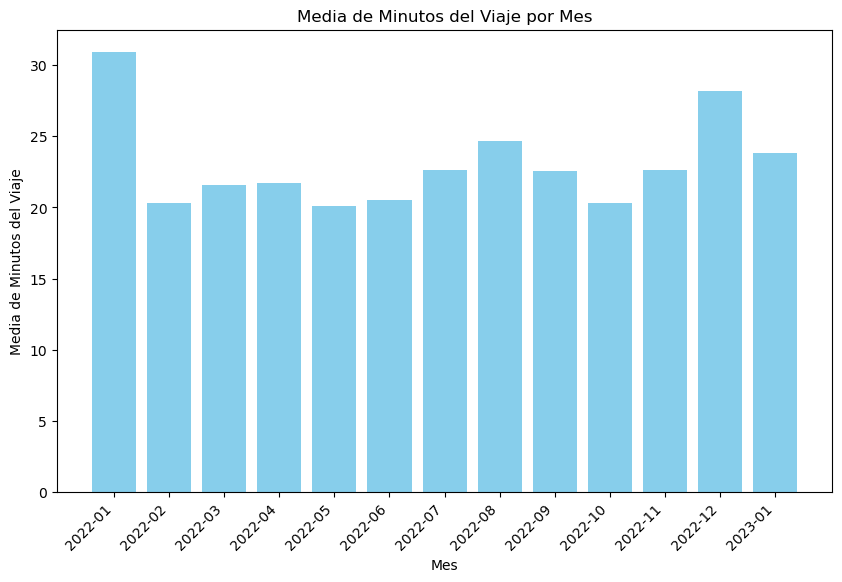

In [26]:
# Creamos una copia del DataFrame original para evitar modificarlo directamente
df_copy = df.copy()

# Nos aseguramos de que la columna 'fecha' sea del tipo datetime en la copia
df_copy['fecha'] = pd.to_datetime(df_copy['fecha'])

# Creamos una nueva columna con el mes en la copia
df_copy['mes'] = df_copy['fecha'].dt.to_period('M')

# Calculamos la media de los minutos del viaje por mes
media_por_mes = df_copy.groupby('mes')['trip_minutes'].mean().reset_index()

# Convertimos objetos Period a int64 primero y luego a int32
media_por_mes['mes_numeric'] = media_por_mes['mes'].astype('int64').astype('int32')

# Mostramos por pantalla los datos 
print(media_por_mes)

# Visualizamos los datos en un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(media_por_mes['mes_numeric'], media_por_mes['trip_minutes'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Media de Minutos del Viaje')
plt.title('Media de Minutos del Viaje por Mes')
plt.xticks(media_por_mes['mes_numeric'], media_por_mes['mes'].astype(str), rotation=45, ha='right')
plt.show()


                    Nombre Estación  Demanda    Latitud  Longitud
180         39 - Plaza de la Cebada    44546  40.411274 -3.708834
144         53 - Plaza de LavapiÃ©s    42672  40.408306 -3.700711
204                167 - Segovia 45    36698  40.413736 -3.717487
42        212 - MarquÃ©s de Vadillo    35536  40.398247 -3.716591
526                   200 - Quevedo    32879  40.433694 -3.704667
317           85 - Puerta de Madrid    32376  40.421501 -3.680008
192             41 - AntÃ³n MartÃ­n    31405  40.412205 -3.699115
121           45 - Puerta de Toledo    29952  40.407036 -3.711051
323       161 - Paseo de la Florida    28689  40.421967 -3.722498
294  60 - Plaza de la Independencia    28571  40.419752 -3.688398


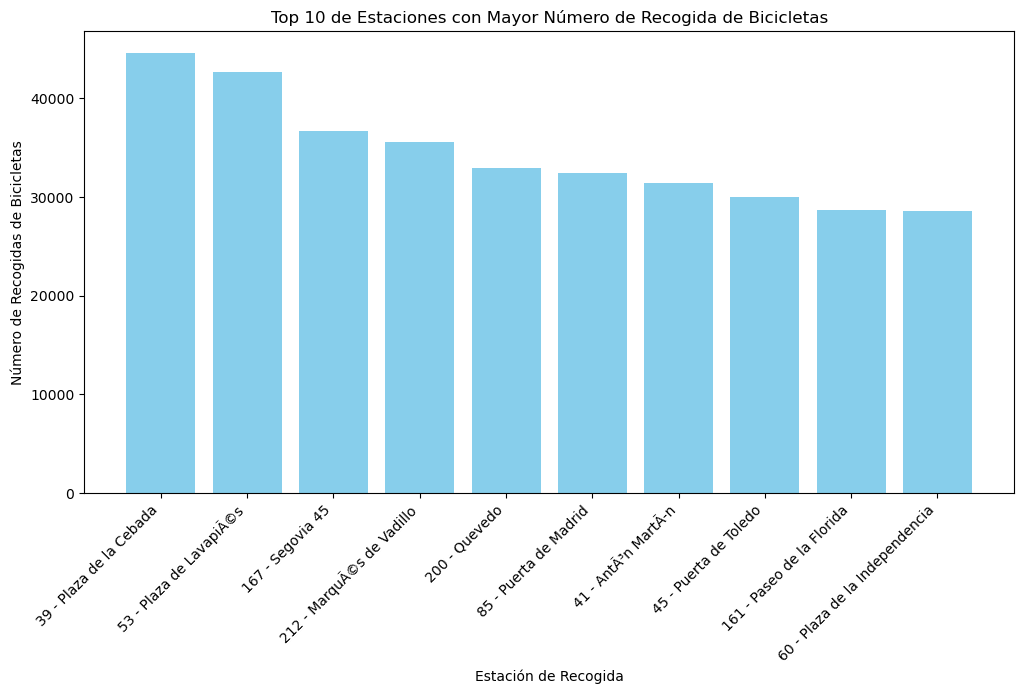

In [27]:
# Agrupamos por estaciones de recogida y contamos las recogidas de bicicletas
top_estaciones = df.groupby(['geolocation_unlock_latitud', 'geolocation_unlock_longitud', 'unlock_station_name']).size().reset_index(name='count')

# Obtenemos el Top 10 de estaciones con mayor número de recogida de bicicletas
top_10_estaciones_unlock = top_estaciones.nlargest(10, 'count')

# Creamos un nuevo DataFrame con detalles de las Top 10 estaciones
top_10_estaciones_detalles = pd.DataFrame({
    'Nombre Estación': top_10_estaciones_unlock['unlock_station_name'],
    'Demanda': top_10_estaciones_unlock['count']
})

# Extraemos las coordenadas del DataFrame en 'geolocation_unlock_latitud' y 'geolocation_unlock_longitud'
top_10_estaciones_detalles[['Latitud', 'Longitud']] = top_10_estaciones_unlock[['geolocation_unlock_latitud', 'geolocation_unlock_longitud']]

# Mostramos el nuevo DataFrame
print(top_10_estaciones_detalles)

# Visualizamos los datos en un gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(top_10_estaciones_unlock['unlock_station_name'], top_10_estaciones_unlock['count'], color='skyblue')
plt.xlabel('Estación de Recogida')
plt.ylabel('Número de Recogidas de Bicicletas')
plt.title('Top 10 de Estaciones con Mayor Número de Recogida de Bicicletas')
plt.xticks(rotation=45, ha='right')
plt.show()


               Nombre Estación  Demanda    Latitud  Longitud
121    39 - Plaza de la Cebada    44922  40.411274 -3.708834
97     53 - Plaza de LavapiÃ©s    41943  40.408306 -3.700711
28   212 - MarquÃ©s de Vadillo    38581  40.398247 -3.716591
137           167 - Segovia 45    37258  40.413736 -3.717487
357              200 - Quevedo    33370  40.433694 -3.704667
221  161 - Paseo de la Florida    32146  40.421967 -3.722498
129        41 - AntÃ³n MartÃ­n    31801  40.412205 -3.699115
216      85 - Puerta de Madrid    31284  40.421501 -3.680008
139    216 - Puerta del Ãngel    30851  40.413764 -3.728318
81       45 - Puerta de Toledo    30472  40.407036 -3.711051


C:\Users\celiu\anaconda3\envs\proyecto_memoria\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 129 (\x81) missing from current font.



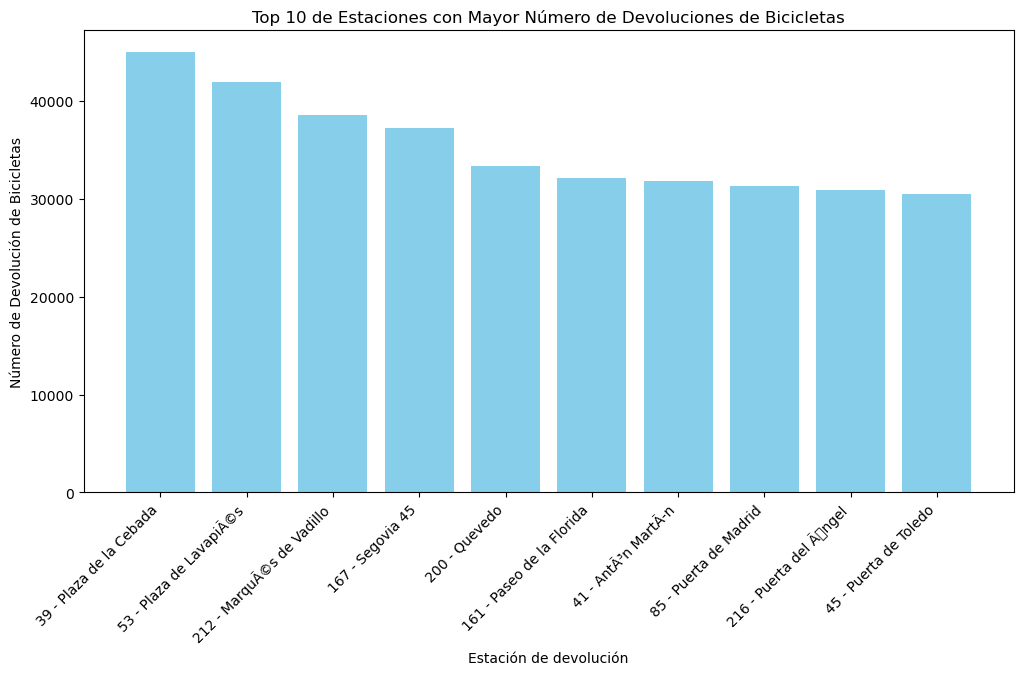

In [28]:
# Agrupamos por estaciones de devolución y contamos las devoluciones de las bicicletas
top_estaciones_lock = df.groupby(['geolocation_lock_latitud', 'geolocation_lock_longitud', 'lock_station_name']).size().reset_index(name='count')

# Obtenemos el Top 10 de estaciones con mayor número de devoluciones de bicicletas
top_10_estaciones_lock = top_estaciones_lock.nlargest(10, 'count')

# Creamos un nuevo DataFrame con detalles de las Top 10 estaciones de devoluciones
top_10_estaciones_lock_detalles = pd.DataFrame({
    'Nombre Estación': top_10_estaciones_lock['lock_station_name'],
    'Demanda': top_10_estaciones_lock['count']
})

# Extraemos las coordenadas del DataFrame en 'geolocation_lock_latitud' y 'geolocation_lock_longitud'
top_10_estaciones_lock_detalles[['Latitud', 'Longitud']] = top_10_estaciones_lock[['geolocation_lock_latitud', 'geolocation_lock_longitud']]

# Mostramos el nuevo DataFrame
print(top_10_estaciones_lock_detalles)

# Visualizamos los datos en un gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(top_10_estaciones_lock['lock_station_name'], top_10_estaciones_lock['count'], color='skyblue')
plt.xlabel('Estación de devolución')
plt.ylabel('Número de Devolución de Bicicletas')
plt.title('Top 10 de Estaciones con Mayor Número de Devoluciones de Bicicletas')
plt.xticks(rotation=45, ha='right')
plt.show()


El número total de rutas canceladas son: 108


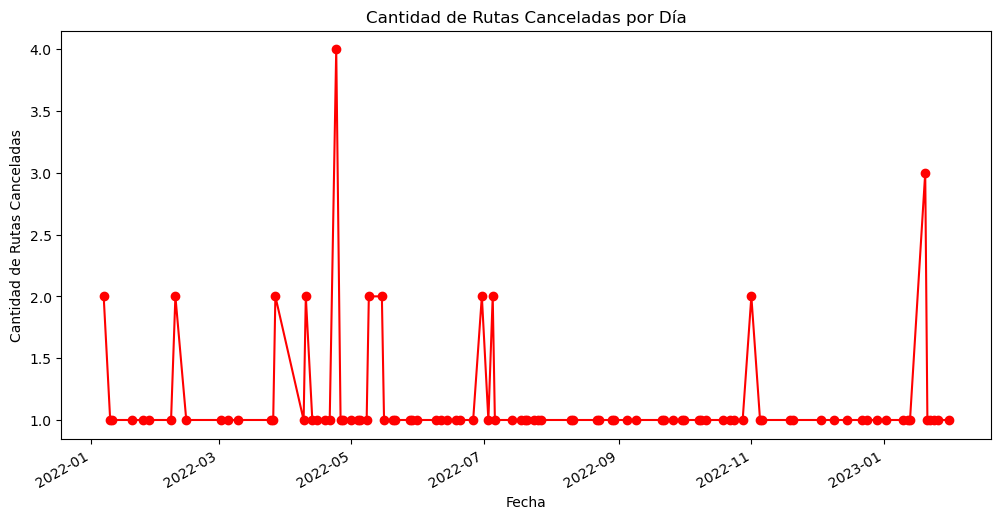

In [29]:
# Filtramos las rutas canceladas (trip_minutes igual a 0)
rutas_canceladas = df[df['trip_minutes'] == 0]

# Contamos la cantidad de rutas canceladas por cada día (o cualquier otra categoría relevante)
cancelaciones_por_dia = rutas_canceladas['fecha'].value_counts().sort_index()


print(f"El número total de rutas canceladas son: { len(rutas_canceladas)}")
# Visualizamos los datos en un gráfico de línea
plt.figure(figsize=(12, 6))
cancelaciones_por_dia.plot(kind='line', marker='o', color='red')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Rutas Canceladas')
plt.title('Cantidad de Rutas Canceladas por Día')
plt.show()


### Predicción

14:44:05 - cmdstanpy - INFO - Chain [1] start processing
14:44:06 - cmdstanpy - INFO - Chain [1] done processing


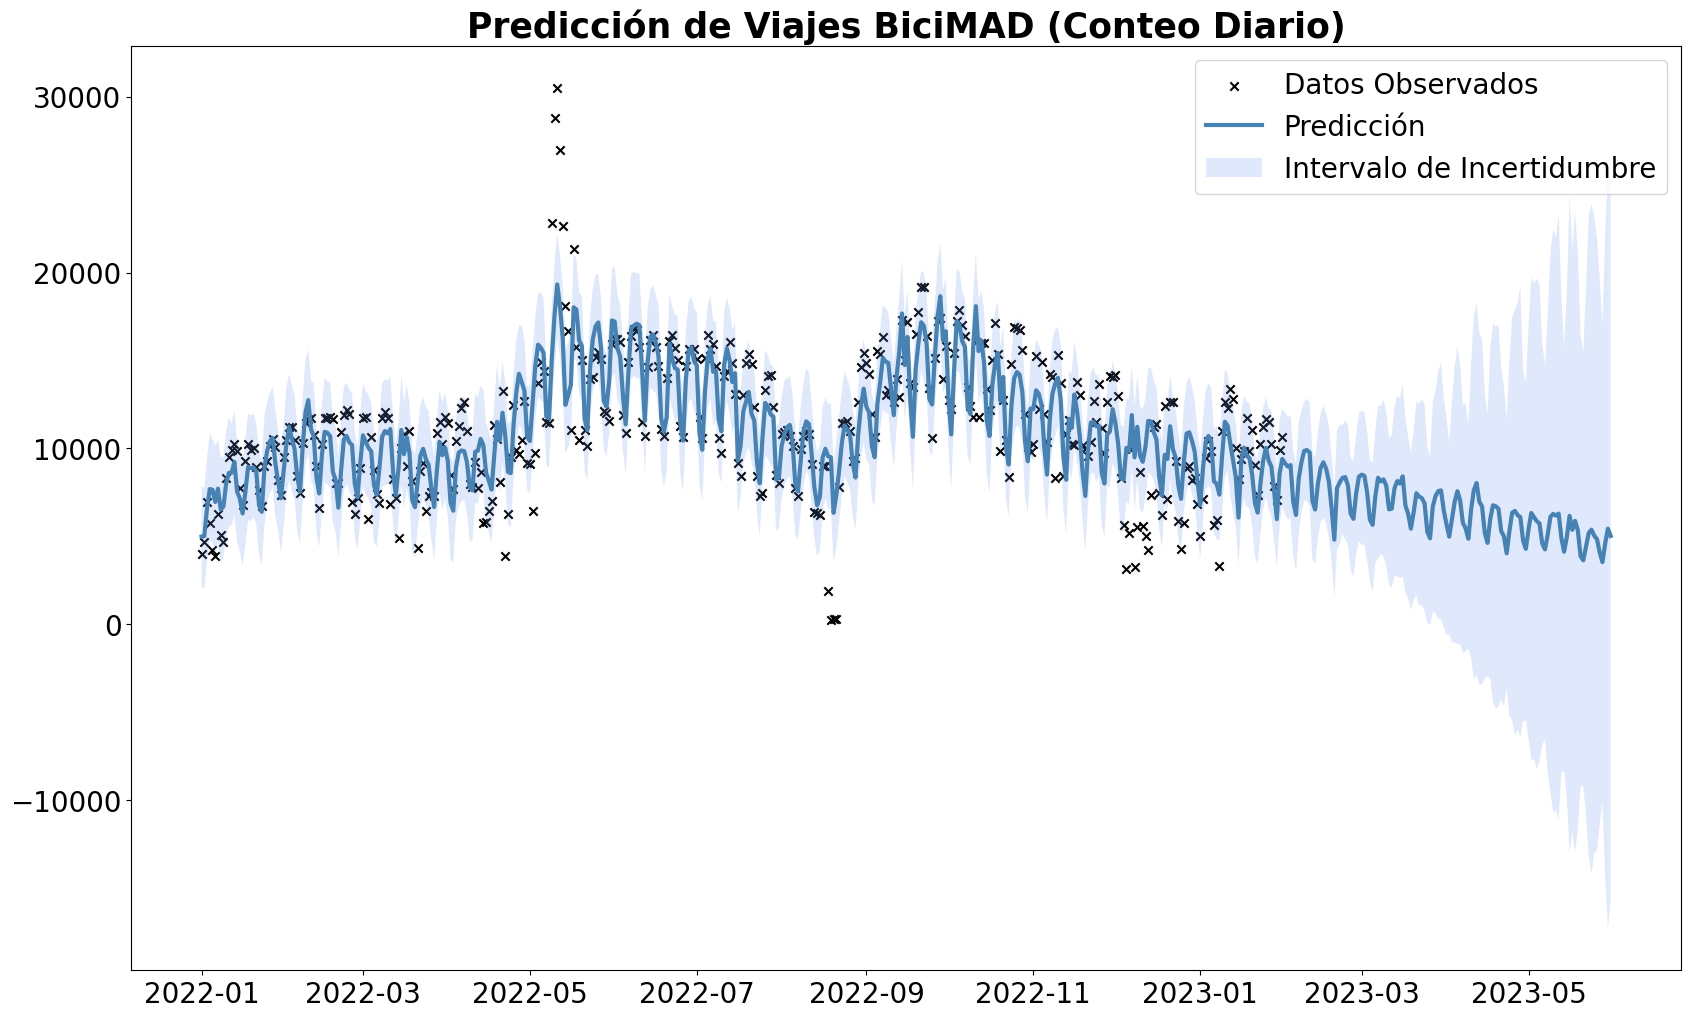

In [30]:
# Dividimos los datos en entrenamiento y prueba
train_size = int(len(df))
train_df, test_df = df[:train_size], df[train_size:]

# Convertimos la columna 'fecha' al formato de fecha de pandas
train_df['fecha'] = pd.to_datetime(train_df['fecha'], format='%Y-%m-%d')

# Creamos un DataFrame para el entrenamiento con columnas ya renombradas y fechas convertidas
daily_counts = train_df.groupby('fecha').size().reset_index(name='y')
daily_counts.columns = ['ds', 'y']

# Configuramos y entrenamos el modelo Prophet
model = Prophet(daily_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative', yearly_seasonality=False)
model.add_seasonality(name='monthly', period=30.5, fourier_order=20)
model.add_country_holidays(country_name='ES')
model.fit(daily_counts)

# Extendemos el período de predicción hasta junio de 2023
future = model.make_future_dataframe(periods=365, freq='D')  

# Realizar las predicciones
forecast = model.predict(future)

# Ajustar rango de fechas para el gráfico
start_date = '2022-01-01'
end_date = '2023-05-31'  # Extender el rango hasta junio de 2023 para que pueda predecir datos

# Filtramos datos para el período específico
daily_counts_filtered = daily_counts[(daily_counts['ds'] >= start_date) & (daily_counts['ds'] <= end_date)]
forecast_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

# Mostrmos los resultados en una gráfica 
f, ax = plt.subplots(figsize=(20, 12))
ax.scatter(daily_counts_filtered.ds, daily_counts_filtered.y, marker='x', color='k', label='Datos Observados')
ax.plot(forecast_filtered.ds, forecast_filtered.yhat, 'steelblue', lw=3, label='Predicción')
plt.fill_between(forecast_filtered.ds, forecast_filtered.yhat_lower, forecast_filtered.yhat_upper, facecolor='cornflowerblue', 
                 alpha=0.2, label='Intervalo de Incertidumbre')

plt.legend(fontsize=20)
plt.title('Predicción de Viajes BiciMAD (Conteo Diario)', fontsize=25, fontweight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


In [31]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(365))

            ds         yhat     yhat_lower     yhat_upper
396 2023-02-01  9151.907701    6226.529578   12026.609579
397 2023-02-02  8967.343292    5984.188286   11789.450844
398 2023-02-03  9055.777438    5996.914263   11890.744240
399 2023-02-04  6962.025023    3872.843497    9849.742603
400 2023-02-05  6217.898497    3006.196496    9135.749322
..         ...          ...            ...            ...
756 2024-01-27 -2442.106147  -89196.263082   79956.518998
757 2024-01-28 -2299.566743  -83780.167839   74941.978081
758 2024-01-29 -3138.305687 -113621.234733  102090.514854
759 2024-01-30 -3237.177024 -118086.644922  104679.730542
760 2024-01-31 -3656.446721 -133432.951354  117059.367925

[365 rows x 4 columns]


In [32]:
# Cargar los datos reales de febrero de 2023 desde un archivo CSV
datos_reales_febrero = pd.read_csv('trips_23_02_February.csv', sep=';', encoding='ISO-8859-1')

# Convertir la columna 'fecha' al formato de fecha de pandas
datos_reales_febrero['fecha'] = pd.to_datetime(datos_reales_febrero['fecha'], format='%Y-%m-%d')

# Se eliminan las filas que contienen solo valores nulos o vacíos ya que los archivos CSV van separados por una fila en blanco
datos_reales_febrero.dropna(how='all', inplace=True)
datos_reales_febrero.head(5)

fecha  idBike  fleet  trip_minutes  \
1 2023-02-01  7337.0    1.0          5.52   
3 2023-02-01  5098.0    1.0          0.32   
5 2023-02-01  6519.0    1.0          0.27   
7 2023-02-01  2551.0    1.0          8.58   
9 2023-02-01  6519.0    1.0          0.20   

                                  geolocation_unlock  \
1  {'type': 'Point', 'coordinates': [-3.6956178, ...   
3  {'type': 'Point', 'coordinates': [-3.7022591, ...   
5  {'type': 'Point', 'coordinates': [-3.6894193, ...   
7  {'type': 'Point', 'coordinates': [-3.7022591, ...   
9  {'type': 'Point', 'coordinates': [-3.6894193, ...   

                    address_unlock          unlock_date locktype unlocktype  \
1             'Calle JesÃºs nÂº 1'  2023-02-01T00:00:10  STATION    STATION   
3  'Glorieta de Embajadores nÂº 2'  2023-02-01T00:00:25  STATION    STATION   
5     'Calle Antonio Maura nÂº 15'  2023-02-01T00:00:36  STATION    STATION   
7  'Glorieta de Embajadores nÂº 2'  2023-02-01T00:00:53  STATION    STATION   
9     'Calle Antonio Maura nÂº 15'  2023-02-01T00:00:57  STATION    STATION   

                                    geolocation_lock  \
1  {'type': 'Point', 'coordinates': [-3.7088337, ...   
3  {'type': 'Point', 'coordinates': [-3.7022591, ...   
5  {'type': 'Point', 'coordinates': [-3.6894193, ...   
7  {'type': 'Point', 'coordinates': [-3.6991147, ...   
9  {'type': 'Point', 'coordinates': [-3.6894193, ...   

                      address_lock            lock_date  station_unlock  \
1     'Plaza de la Cebada nÂº 16 '  2023-02-01T00:05:41            31.0   
3  'Glorieta de Embajadores nÂº 2'  2023-02-01T00:00:44            52.0   
5     'Calle Antonio Maura nÂº 15'  2023-02-01T00:00:52            69.0   
7            'Calle Atocha nÂº 54'  2023-02-01T00:09:28            52.0   
9     'Calle Antonio Maura nÂº 15'  2023-02-01T00:01:09            69.0   

   dock_unlock unlock_station_name  station_lock  dock_lock  \
1          3.0        27 - Huertas          43.0        3.0   
3         22.0  48 - Embajadores 2          52.0       22.0   
5          9.0  65 - Antonio Maura          69.0        9.0   
7         23.0  48 - Embajadores 2          45.0        3.0   
9          9.0  65 - Antonio Maura          69.0        9.0   

         lock_station_name  
1  39 - Plaza de la Cebada  
3       48 - Embajadores 2  
5       65 - Antonio Maura  
7      41 - AntÃ³n MartÃ­n  
9       65 - Antonio Maura

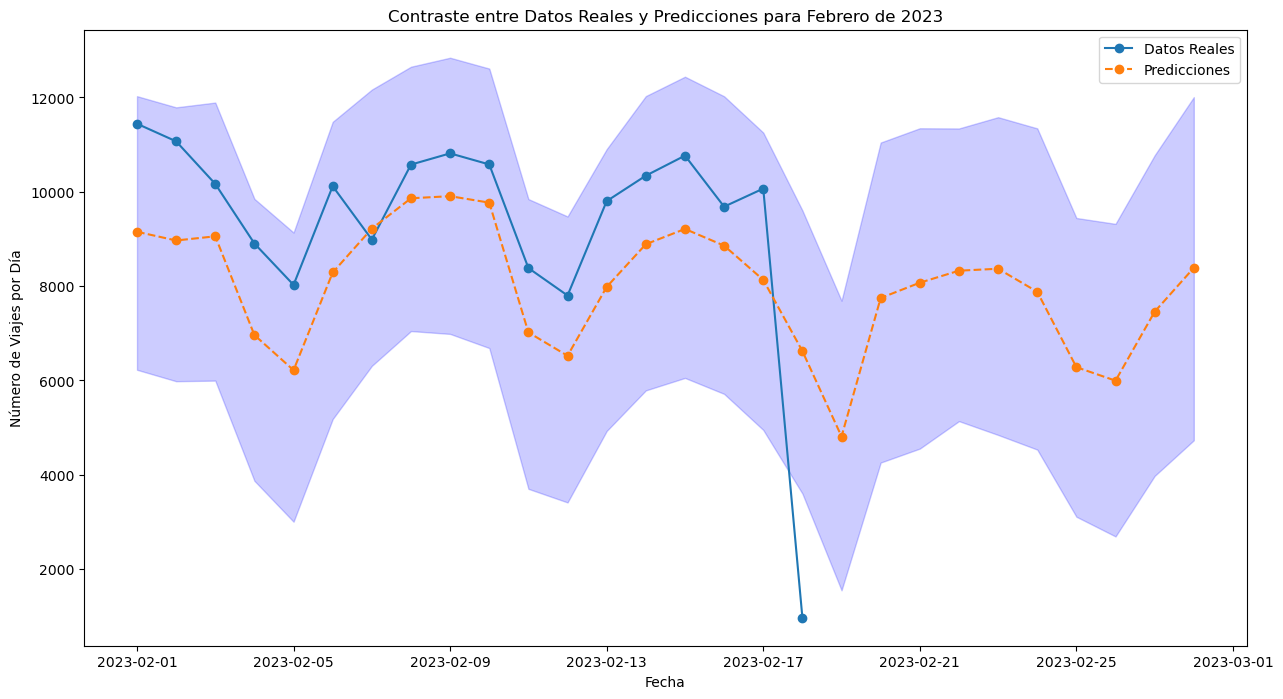

In [33]:

# Agrupar por fecha y contar el número de viajes por día
viajes_por_dia_reales = datos_reales_febrero.groupby('fecha').size().reset_index(name='viajes')

# Filtrar la predicción para febrero de 2023
predicciones_febrero = forecast[(forecast['ds'] >= '2023-02-01') & (forecast['ds'] <= '2023-02-28')]

# Visualizar y comparar datos reales y predicciones
plt.figure(figsize=(15, 8))
plt.plot(viajes_por_dia_reales['fecha'], viajes_por_dia_reales['viajes'], label='Datos Reales', marker='o')
plt.plot(predicciones_febrero['ds'], predicciones_febrero['yhat'], label='Predicciones', linestyle='--', marker='o')
plt.fill_between(predicciones_febrero['ds'], predicciones_febrero['yhat_lower'], predicciones_febrero['yhat_upper'], alpha=0.2, color='blue')

plt.xlabel('Fecha')
plt.ylabel('Número de Viajes por Día')
plt.title('Contraste entre Datos Reales y Predicciones para Febrero de 2023')
plt.legend()
plt.show()